In [1]:
import sys
sys.path.append('..') 
import os

import psycopg2
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

# Main

## Data Loading

In [2]:
# """DataLoad"""
# from src.utils.config import get_config
# from src.db_ops.db_ops import PosgreOps

# # Load Config
# config = get_config()
# # Initialize database operator, this case posgre operator
# pgops = PosgreOps(config=config)
# ### Define the required parameters to load the data ###
# # -------------------------------------------------------- #
# months = 84
# table_name = "daas.epdk_petrol_province"
# # -------------------------------------------------------- #
# # Fetch data from database
# epdk_petrol_province_data = pgops.get_monthly_data(table_name=table_name,
#                                                 today=date.today(), months=months)
# # Close the connection after obtaining the data
# pgops.shutdown()

In [3]:
# # Investigate Results
# print(epdk_petrol_province_data.shape)
# print(epdk_petrol_province_data.province.nunique())
# print(epdk_petrol_province_data.date.min())

In [4]:
# epdk_petrol_province_data.date.dtypes

In [5]:
# Load Raw data
epdk_petrol_province_data = pd.read_csv('data/daas_raw_data.csv', index_col=[0])
epdk_petrol_province_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5904 entries, 0 to 5903
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            5904 non-null   object 
 1   province        5904 non-null   object 
 2   gasolene_types  5904 non-null   float64
 3   diesel_types    5904 non-null   float64
 4   fuel_oil_types  5890 non-null   float64
 5   aviation_fuels  5875 non-null   float64
 6   marine_fuels    5826 non-null   float64
 7   paraffin_oil    5838 non-null   float64
 8   other_types     5824 non-null   float64
 9   total           5904 non-null   float64
 10  percentage      5904 non-null   float64
dtypes: float64(9), object(2)
memory usage: 553.5+ KB


## Preprocessing

In [6]:
"""Preprocessing"""
from src.preprocessing.preprocess import PreprocessData

# Initialize preprocess object
prep = PreprocessData(data=epdk_petrol_province_data)
### Define parameters to preprocess ###
# -------------------------------------------------------- #
target_col_list = ["date","province","diesel_types"]
row_drop_dict = {"province": "Toplam"} 
# format_date_flag = True # True by default
col_rename_dict = {"diesel_types":"current_month_consumption"}
anomaly_col = "current_month_consumption" 
# -------------------------------------------------------- #
# Preprocess data with given parameters
preprocessed_df = prep.preprocess_data(target_col_list=target_col_list,
                                 row_drop_dict=row_drop_dict,
                                 col_rename_dict=col_rename_dict,
                                 anomaly_col=anomaly_col)


Missing Dates are:  [numpy.datetime64('2021-10-01T00:00:00.000000000')]


In [7]:
# Investigate results
print(preprocessed_df.shape)
print(preprocessed_df.province.nunique())
print(preprocessed_df.date.min())

(5913, 3)
81
2016-01-01 00:00:00


In [8]:
preprocessed_df.tail()

,date,province,current_month_consumption
5834,2022-01-01,ÇORUM,7030.322
5849,2022-01-01,İSTANBUL,312346.398
5851,2022-01-01,İZMİR,93476.673
5894,2022-01-01,ŞANLIURFA,19790.450
5882,2022-01-01,ŞIRNAK,5701.813


In [9]:
# Control whether the missing values at 2021-10-01 are filled 
preprocessed_df.query(f"date=='{date(2021,10,1)}'").sort_values(by="current_month_consumption").tail()

,date,province,current_month_consumption
5669,2021-10-01,KONYA,76596.319000
5607,2021-10-01,BURSA,86588.115500
5608,2021-10-01,İZMİR,110690.847500
5617,2021-10-01,ANKARA,186113.792667
5606,2021-10-01,İSTANBUL,323780.346000


In [10]:
# # Save preprocessed data
# preprocessed_df.to_csv("data/preprocessed_df.csv")
# # Load preprocessed data
# parse_dates = ["date"]
# preprocessed_df = pd.read_csv('data/preprocessed_df.csv', index_col=[0], parse_dates=parse_dates)
# preprocessed_df.info()

## Plotting

Shape of dataframe is :  (73, 3)


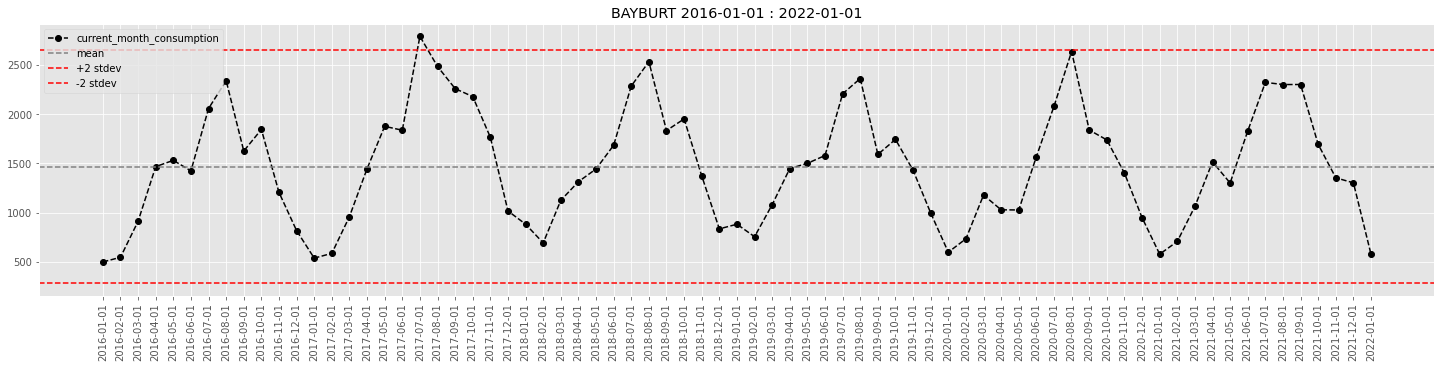

In [11]:
"""Plotting"""
from src.utils.plotting import plot_province

plot_province(df=preprocessed_df, col_x="date", col_y="current_month_consumption", province="BAYBURT", stdev=2)

## Feature Engineering

In [12]:
"""FeatureEngineering"""
from src.feature_engineering.feat_eng import FeatureEngineering

# Initialize feature engineering object
feng = FeatureEngineering(data=preprocessed_df)
# Apply feature engineering to the preprocessed data
feature_engineered_df = feng.feature_engineering()

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros 

In [13]:
feature_engineered_df.head()

,date,province,current_month_consumption,ARIMA_prediction,last_year_total_consumption,rolling_mean_2,rolling_mean_3,lag1_monthly_share,lag2_monthly_share,lag3_monthly_share,...,lag3,quarter,month,covid,school_holiday,population,trend,yhat_lower,yhat_upper,yhat
14,2017-03-01,ADANA,40979.795,37922.039204,549329.180,38272.2655,40510.141667,0.074600,0.068349,0.070209,...,44985.894,1,3,0,8,2216475.0,46031.314852,38892.171600,50452.315069,44574.286007
15,2017-04-01,ADANA,41359.841,40690.801551,550052.298,39373.9460,39174.775333,0.075193,0.074600,0.068349,...,38776.434,2,4,0,10,2216475.0,46101.463604,37244.333162,48677.455994,42954.267992
16,2017-05-01,ADANA,44928.990,41296.608999,545723.008,41169.8180,40035.911000,0.082329,0.075193,0.074600,...,37768.097,2,5,0,10,2216475.0,46169.349492,39639.999584,51441.309575,45741.344966
17,2017-06-01,ADANA,51147.202,44585.687793,542067.715,43144.4155,42422.875333,0.094356,0.082329,0.075193,...,40979.795,2,6,0,21,2216475.0,46239.498245,43213.622515,54558.996283,48676.467322
18,2017-07-01,ADANA,52226.264,50527.062674,543580.982,48038.0960,45812.011000,0.096078,0.094356,0.082329,...,41359.841,3,7,0,31,2216475.0,46307.384134,43955.057188,55361.085501,49834.030167


In [14]:
print(feature_engineered_df.shape)
feature_engineered_df.query("current_month_consumption%1==0")

(4779, 22)


,date,province,current_month_consumption,ARIMA_prediction,last_year_total_consumption,rolling_mean_2,rolling_mean_3,lag1_monthly_share,lag2_monthly_share,lag3_monthly_share,...,lag3,quarter,month,covid,school_holiday,population,trend,yhat_lower,yhat_upper,yhat
617,2018-10-01,ARTVİN,5115.0,4793.323548,56028.585,5108.402,5102.234333,0.091293,0.084958,0.096013,...,5089.899,4,10,0,9,174010.0,4675.068692,4852.374034,6086.878555,5451.085085
2612,2020-10-01,IĞDIR,7641.0,3217.088422,33596.568,3535.211,3553.936333,0.227434,0.107657,0.116035,...,3591.387,4,10,1,10,201314.0,2698.905093,3336.614033,5022.042523,4181.539923


In [15]:
# feature_engineered_df.query("province == 'ARTVİN'")

Shape of dataframe is :  (59, 22)


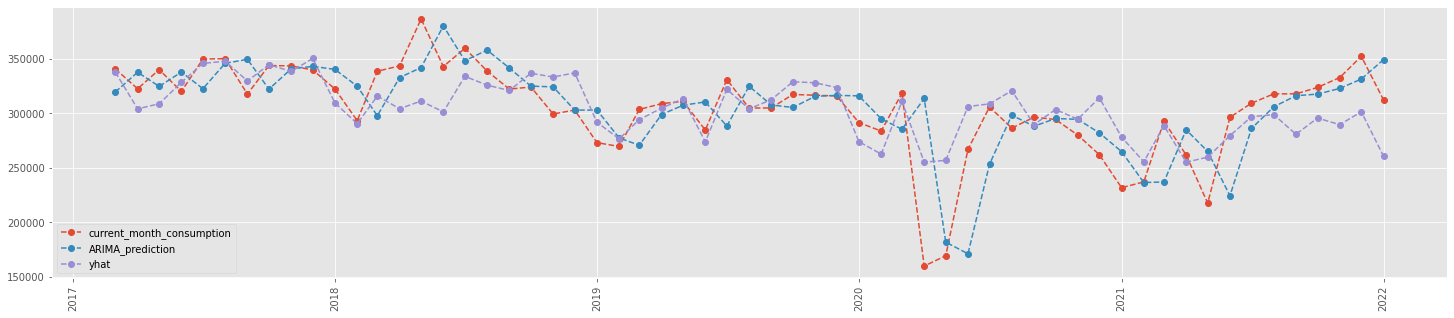

In [16]:
from src.utils.plotting import plot_metrics
plot_metrics(feature_engineered_df.query("province == 'İSTANBUL'"), col_x="date", col_y1="current_month_consumption", col_y2="ARIMA_prediction", col_y3="yhat")

In [17]:
# Save feature_engineered_df 
feature_engineered_df.to_csv("data/feature_engineered_df.csv")